<a href="https://colab.research.google.com/github/Mathis1993/DCGAN/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Choose Hardware Accelerator

To run on GPU, from the menu, select
* Runtime -> Change Runtime Type -> Hardware Accelerator --> GPU


Before starting, we want to mount our Google Drive to have access to our data in colab.

## Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next, navigate to the directory holding our data.

In [0]:
%cd /content/drive/My Drive/Colab Notebooks/DCGAN/
#%cd /content/drive/My Drive/

[Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/DCGAN/'
/content


Now, we can get started with our Deep Convolutional Generative Adversarial Network (DCGAN).

## DCGAN

We want to create a network through which we are able to generate images of faces that look as real as possible. Or, put differently, we want a network to learn the distribution of face data, to be able to sample new data (new faces) from that distribution.

This tutorial is mainly inspired by [this official pytorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) by Nathan Inkawhich.

### Imports

In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

#Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed) #set randoms' random seed
torch.manual_seed(manualSeed) #set pytorch's random seed

Random Seed:  999


### Parameters

The hyperparameters' values (set here and in the model section) are best practice recommendations from [this paper](https://arxiv.org/pdf/1511.06434.pdf).

In [0]:
#Root directory for dataset
dataroot = "data/celeba"

#Number of workers for dataloader
workers = 2

#size using a transformer.
image_size = 64

#Batch size during training
batch_size = 128

#Number of training epochs
num_epochs = 20

#Learning rate for optimizers
lr = 0.0002

#Beta1 hyperparam for Adam optimizers
beta1 = 0.5

#Whether to use GPU
gpu = True

### Data

Firts, we specify the structure of our dataset. We set our image folder up in way that we can use it with Pytorch's ImageFolder Dataset-class: In a directory, we have one or more subdirectories containing the images.
We can specify transforms here, that are called when the data is loaded. Here, we resize the images to have 64x64 pixels, we declare them to be tensors and we normalize the range of their values (which orignially are at [0,1] to [-1,1], as this is the range the generator will output later.

In [0]:
#Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

Next, we can feed the dataset into an instance of the DataLoader-class, specifying the batch_size, if batches should be drawn randomly and how many cores should work on retrieving batches in parallel.

In [0]:
#Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

Our dataloader is iterable, so we can call next() on it to retrieve a batch of randomly selected images. We want to plot 64 of these in a grid (conveniently done with pytorch's make_grid-function) to take a peek at our data. Note that we have to swap the tensors' axes (that hold the image data) for plotting. Pytorch usually represents image data as (n_channels x height x width) while numpy does as (height x width x n_channels).
Also, as currently our images are in a range of [-1,1], which pyplot can't work with, we need to normalize them to [0,1] again.

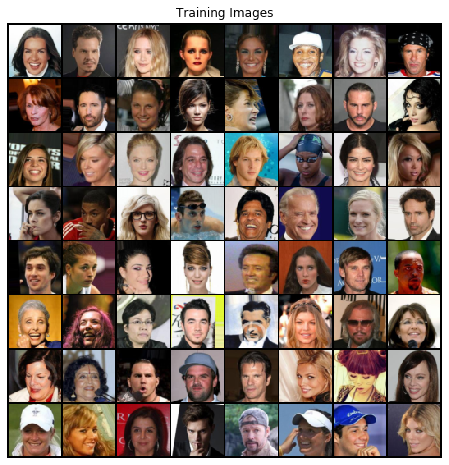

In [0]:
#Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
#dataloader gives tuple of (data-tensor, target-tensor) with targets defaulting to 0
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True),(1,2,0))) #normalize from [-1,1] to [0,1] again

## GPU device

In [0]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and gpu) else "cpu")
print(device)

cuda:0


### Weight Initialization

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Models
We have two physical models:
1. The **discriminator**: A regular CNN taking a batch of images as an input, and classifying for each image if it believes it to be real or not. It outputs the probability of an image being real (in its opinion).

2. The **generator**: Into this model, we feed a vector of random numbers (drawn from the standard normal distribution). These are transformed into a 3x64x64 color image. We want this image to look real (we want the generator to capture the images' distribution).

#### Discriminator

In [0]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(negative_slope=0.2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=128),
        nn.LeakyReLU(negative_slope=0.2)
    )

    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=256),
        nn.LeakyReLU(negative_slope=0.2)
    )

    self.conv_block4 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=512),
        nn.LeakyReLU(negative_slope=0.2)
    )

    self.conv_block5 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.conv_block3(x)
    x = self.conv_block4(x)
    x = self.conv_block5(x)
    return x

#### Generator

In [0]:
class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()
    
    self.convT_block1 = nn.Sequential(
        #100 x 1 x 1
        nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )

    self.convT_block2 = nn.Sequential(
        #512 x 4 x 4
        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )

    self.convT_block3 = nn.Sequential(
        #256 x 8 x 8
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )

    self.convT_block4 = nn.Sequential(
        #128 x 16 x 16
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.convT_block5 = nn.Sequential(
        #64 x 32 x 32
        nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )
        #3 x 64 x 64

  def forward(self, x):
    x = self.convT_block1(x)
    x = self.convT_block2(x)
    x = self.convT_block3(x)
    x = self.convT_block4(x)
    x = self.convT_block5(x)
    return x


#### Instantiate Models

This will also give an overview of the models.

Discriminator

In [0]:
discriminator = Discriminator().to(device)

#initialize weights
discriminator.apply(weights_init)

Discriminator(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), st

Generator

In [0]:
generator = Generator().to(device)

#initialize weights
generator.apply(weights_init)

Generator(
  (convT_block1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convT_block2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convT_block3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convT_block4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convT_block5): Sequential(
    (0): ConvTranspose2d(

### Loss Function

In [0]:
criterion = nn.BCELoss()

### Optimizers

In [0]:
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

In [0]:
#batch_size = 20
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                         shuffle=True, num_workers=workers)
#label_real = torch.full(size=(batch_size,), fill_value=1)
#label_fake = torch.full(size=(batch_size,), fill_value=0)

In [0]:
#real_batch = next(iter(dataloader))
#data = real_batch[0]
#output = discriminator(data)

In [0]:
#z = torch.randn(batch_size, 100, 1, 1)
# Generate fake image batch with G
#data_fake = generator(z)

In [0]:
#To track how the latent space is given sense
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

#To track progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
#For each epoch
for epoch in range(num_epochs):
    
    #For each batch in the dataloader
    for i, data in enumerate(dataloader, 0): #at what index to start

      #extract real images from list holding data and nonsense targets
      #and push to device
      data_real = data[0].to(device)

      #calculate acutal batch size (in the last batch per epoch, it could be != our determined batch_size)
      b_size = data_real.size(0)

      #targets
      label_real = torch.full(size=(b_size,), fill_value=1).to(device)
      label_fake = torch.full(size=(b_size,), fill_value=0).to(device)

      #push everything to gpu
      if gpu:
        if torch.cuda.is_available():
          data_real.cuda()
          label_real.cuda()
          label_fake.cuda()

      #train discriminator on real batch
      #zero gradient buffer
      discriminator.zero_grad()
      #forward pass
      output = discriminator(data_real).view(-1)
      #calculate loss
      loss_d_real = criterion(output, label_real)
      #backward pass
      loss_d_real.backward()

      #train discriminator on fake batch
      #Generate batch of latent vectors
      z = torch.randn(b_size, 100, 1, 1, device=device)
      #Generate fake image batch with the generator
      data_fake = generator(z)
      output = discriminator(data_fake.detach()).view(-1) #detach fake images from generator
      loss_d_fake = criterion(output, label_fake)
      loss_d_fake.backward()

      #summarize loss 
      loss_d = loss_d_real + loss_d_fake
      #update discriminator weights
      optimizerD.step()

      #train generator
      generator.zero_grad()
      #as we just updated the discriminator, pass the fake data through it again
      output = discriminator(data_fake).view(-1)
      #use real labels here!
      loss_g = criterion(output, label_real)
      loss_g.backward
      #update generator weights
      optimizerG.step()

      #track losses
      G_losses.append(loss_d.item())
      D_losses.append(loss_g.item())

      #print information
      if (iters % 50 == 0):
        print("[{}/{}], iteration {}, d_loss: {:.3f}, g_loss: {:.3f}".format(epoch+1, num_epochs, iters, loss_d.item(), loss_g.item()))

      #save generated images
      if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

      iters += 1

Starting Training Loop...
[1/20], iteration 0, d_loss: 2.029, g_loss: 4.200
[1/20], iteration 50, d_loss: 0.000, g_loss: 9.378
[2/20], iteration 100, d_loss: 0.000, g_loss: 10.281
[2/20], iteration 150, d_loss: 0.000, g_loss: 11.026
[3/20], iteration 200, d_loss: 0.000, g_loss: 11.295
[3/20], iteration 250, d_loss: 0.000, g_loss: 11.659
[4/20], iteration 300, d_loss: 0.000, g_loss: 12.010
[4/20], iteration 350, d_loss: 0.000, g_loss: 12.173
[5/20], iteration 400, d_loss: 0.000, g_loss: 12.379
[5/20], iteration 450, d_loss: 0.000, g_loss: 12.484
[6/20], iteration 500, d_loss: 0.000, g_loss: 12.702


KeyboardInterrupt: ignored

### Evaluation

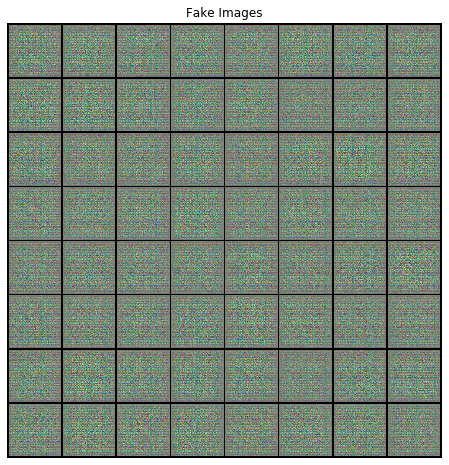

In [0]:
# Plot the fake images from the last epoch
#plt.subplot(1,2,2)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1].cpu(),(1,2,0)))
plt.show()